### Multiple Models and/or Tasks

An important feature of Ledidi is that it can use multiple models in the design process to create edits that control multiple characteristics simultaneously. This capability is practically very useful because, usually, there actually are multiple characteristics that one cares about, even if for many of them the goal is to keep those characteristics the same as before editing. For example, if one wants to increase the binding of MYC in a promoter they usually do not want to do it at the expense of *everything else* including transcription. Rather, they want to increase MYC binding while keeping ~most other aspects the same.

Broadly, these sorts of multi-characteristic designs fall into three related categories:

1. cell type-specific characteristics, where each model or task predicts the same activity but in a different cellular context

2. cross-modal characteristics, where each model or task predicts a different form of activity, usually within the same cellular context

3. misc. design properties, where the models are not necessarily predicting genomic activity directly but rather are predicting something related to how easy the editing process will be for those edits, the likelihood of off-target effects, or whether the edits are still "in-distribution" to the target genome

Using multiple models or tasks is conceptually straightforward: at each step, the edited sequences are passed through the provided model(s) and the loss is calculated for each model or target as specified by the user. These losses are then combined into a single output loss and the gradient is calculated by combining the input and output losses as before. This single gradient update is applied to the underlying weight matrix, and the process continues. Essentially, all that changes is that the output loss is now made up of multiple terms instead of being a single one. 

As a terminological note, we will use "output" to refer to either the predictions from multiple models and/or multiple tasks. Ledidi can use any number of outputs distributed across any number of models (though the number of models will probably be less than the number of outputs).

#### Using All Tasks From One Model

Potentially the simplest multi-output design process comes from when all tasks are used from a model. This usually only happens when a model is trained specifically to subsequently be used for design, but can also coincidentally arise in other situations. One such example is Malinois, which is a Basset-like model that was trained to predict cell type-specific MPRA activity in K562, HepG2, and SK-N-SH cell lines. After training this model, Gosai et al. use standard design methods like greedy substitution and FastSeqProp to design cell type-specific elements <i>de novo</i>.

In [1]:
import torch
from boda.model import BassetBranched

checkpoint = torch.load("../../../../models/malinois/torch_checkpoint.pt", weights_only=False)
malinois = BassetBranched(**vars(checkpoint['model_hparams']))
malinois.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

As our first demonstration of multi-output design, we can use Ledidi + Malinois to design elements with various properties. Gosai et al. introduce and use the idea of the "min-gap" loss to make elements as cell type-specific as possible. Here, we just show how to use multiple outputs. See the tutorial on alternate loss functions to see min-gap in action.

First, we can generate a random sequence and see what Malinois predicts for it.

In [2]:
from tangermeme.utils import random_one_hot
from tangermeme.predict import predict

X = random_one_hot((1, 4, 600), random_state=0).float()

y_orig = predict(malinois, X)
y_orig

tensor([[ 0.0266,  0.1797, -0.1829]])

Looks like low values across the board.

To specify a multi-output design all we need to do is create a tensor of desired outputs that is the same length as the number of outputs from the model. Here, Malinois makes three predictions so we need to specify three values. For shape reasons, the first dimension needs to remain 1, though, because internally Ledidi generates a batch of sequences and needs to calculate the loss for each one.

In [3]:
y_bar = torch.tensor([[0.0, 0.0, 5.0]])
y_bar.shape

torch.Size([1, 3])

Now, we can use Ledidi exactly as before. We pass in the model, the initial sequence `X`, and the desired outputs `y_bar`, where `y_bar` is now a tensor instead of a single number.

In [4]:
from ledidi import ledidi

X_bar = ledidi(malinois, X, y_bar, verbose=True)[0:1]

iter=I	input_loss=0.0	output_loss=8.965	total_loss=8.965	time=0.0
iter=100	input_loss=34.12	output_loss=0.4832	total_loss=3.896	time=1.767
iter=200	input_loss=33.56	output_loss=0.2413	total_loss=3.598	time=1.129
iter=F	input_loss=29.75	output_loss=0.3809	total_loss=3.356	time=3.728


Looks like the output loss has significantly dropped, and not that many edits were necessary in order to achieve that because Ledidi is still using an input loss. 

Now, we can plot the predictions frm the Malinois model before and after editing the sequence.

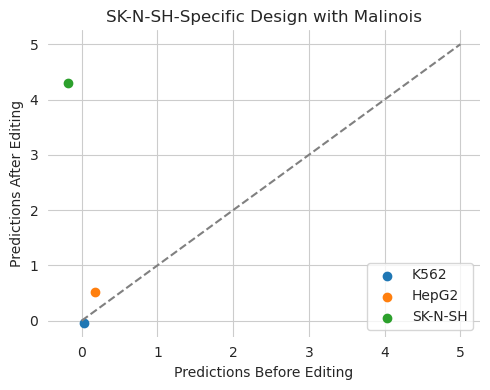

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

y_hat = predict(malinois, X_bar)

plt.figure(figsize=(5, 4))

plt.title("SK-N-SH-Specific Design with Malinois")
plt.scatter(y_orig[0, 0], y_hat[0, 0], label="K562")
plt.scatter(y_orig[0, 1], y_hat[0, 1], label="HepG2")
plt.scatter(y_orig[0, 2], y_hat[0, 2], label="SK-N-SH")
plt.plot([0, 5], [0, 5], c='0.5', linestyle='--')

plt.xlabel("Predictions Before Editing")
plt.ylabel("Predictions After Editing")
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

Ledidi decreased predictions in K562 and HepG2 and significantly increased them in SK-N-SH. The predictions are close to the desired values of 0, 0, and 5 respectively, but not exactly them because, again, Ledidi is balancing the desired output with the input loss. This balance between the input and output loss may become much more important when the output loss is a complicated mixture of terms. As a refresher, we can reduce the impact of the input loss by decreasing lambda.

In [6]:
X_bar = ledidi(malinois, X, y_bar, l=0.001, verbose=True)[0:1]

iter=I	input_loss=0.0	output_loss=8.965	total_loss=8.965	time=0.0
iter=100	input_loss=144.9	output_loss=0.3198	total_loss=0.4648	time=1.242
iter=200	input_loss=109.2	output_loss=0.05467	total_loss=0.1639	time=1.236
iter=300	input_loss=97.88	output_loss=0.04219	total_loss=0.1401	time=1.233
iter=400	input_loss=106.8	output_loss=0.02486	total_loss=0.1316	time=1.238
iter=F	input_loss=98.25	output_loss=0.003906	total_loss=0.1022	time=5.301


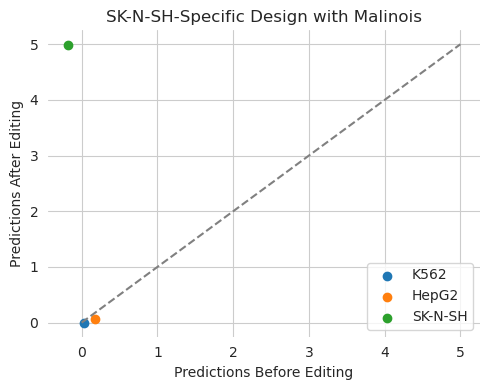

In [7]:
y_hat = predict(malinois, X_bar)

plt.figure(figsize=(5, 4))

plt.title("SK-N-SH-Specific Design with Malinois")
plt.scatter(y_orig[0, 0], y_hat[0, 0], label="K562")
plt.scatter(y_orig[0, 1], y_hat[0, 1], label="HepG2")
plt.scatter(y_orig[0, 2], y_hat[0, 2], label="SK-N-SH")
plt.plot([0, 5], [0, 5], c='0.5', linestyle='--')

plt.xlabel("Predictions Before Editing")
plt.ylabel("Predictions After Editing")
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

Although we end up using more edits, we get significantly closer to our desired goals. Even a small input loss can be very useful in keeping the edited sequence close to the initial one.

Because our default loss is based on matching specific values, we can design cell type-specific elements as above by setting some of those to be low but we can also set them to any sort of combinatorial pattern we would like. We can design elements that exhibit transcription in every cell type!

In [8]:
y_bar = torch.tensor([[5.0, 5.0, 5.0]])
X_bar1 = ledidi(malinois, X, y_bar, verbose=True)[0:1]

iter=I	input_loss=0.0	output_loss=24.94	total_loss=24.94	time=0.0
iter=100	input_loss=20.75	output_loss=0.1256	total_loss=2.201	time=1.212
iter=200	input_loss=15.31	output_loss=0.1126	total_loss=1.644	time=1.235
iter=300	input_loss=13.62	output_loss=0.09684	total_loss=1.459	time=1.241
iter=400	input_loss=12.12	output_loss=0.08817	total_loss=1.301	time=1.211
iter=F	input_loss=10.31	output_loss=0.0599	total_loss=1.091	time=5.927


Hooray! And it doesn't even take that many edits to do so. Probably because it is relying on features that are common across all three cell lines instead of editing in three distinct regulatory programs.

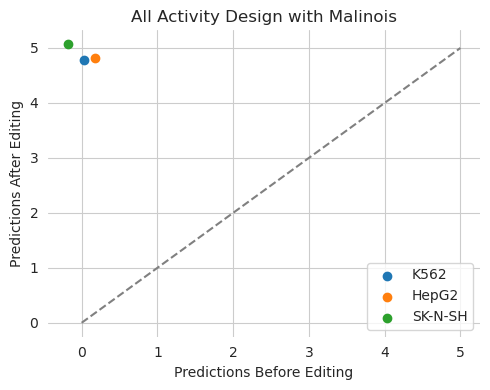

In [9]:
y_hat1 = predict(malinois, X_bar1)

plt.figure(figsize=(5, 4))

plt.title("All Activity Design with Malinois")
plt.scatter(y_orig[0, 0], y_hat1[0, 0], label="K562")
plt.scatter(y_orig[0, 1], y_hat1[0, 1], label="HepG2")
plt.scatter(y_orig[0, 2], y_hat1[0, 2], label="SK-N-SH")
plt.plot([0, 5], [0, 5], c='0.5', linestyle='--')

plt.xlabel("Predictions Before Editing")
plt.ylabel("Predictions After Editing")
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

#### Using Some Tasks from One Model

By now, several massively multi-task genomics models have been released that make accurate predictions for a breadth of outputs and have been rigorously validated. It makes sense that one may want to use these models in design, particularly when the alternative is having to train and validate your own models. At tis point the canonical mulit-task model in genomics is Enformer. However, trying to figure out appropriate values to set all 5,313 human outputs to -- particularly when many of these outputs are redundant -- can make using it infeasible.

A way to circumvent this challenge is to use only a subset of outputs from these models. PyTorch makes this easy through the use of wrappers where one can alter inputs before they go into a model and alter outputs before they are returned to the user. See [this tutorial](https://tangermeme.readthedocs.io/en/latest/vignettes/Wrappers_are_Productivity_Hacks.html) for a detailed description of how one can use wrappers to improve productivity in genomics ML.

Specifically, here we can write a wrapper that takes in a ML model and returns only a subset of the output predictions and discards the rest. Because the other outputs are discarded, you do not need to think about what appropriate values for them may be. See the tutorial above for what each part of this wrapper is doing, because it is also making Enformer an easier model to work with.

In [10]:
class EnformerWrapper(torch.nn.Module):
    def __init__(self, model, targets):
        super(EnformerWrapper, self).__init__()
        self.model = model
        self.targets = targets
    
    def forward(self, X):
        y = self.model(X.permute(0, 2, 1))['human']
        return torch.log(y.sum(dim=1)[:, self.targets] + 1)

Next, we can use the Enformer model hosted frm EleutherAI. An interesting aspect of the implementation is that it allows the model to run at any multiple of 128 that one would want. The models are not retrained at these other lengths and so weird artifact can (and do) creep it at small lengths. However, for demonstration purposes, using a small length can really speed things up. 

Let's start off by using DNase, GATA2, and MAX predictions in K562.

In [11]:
import os
os.environ['POLARS_ALLOW_FORKING_THREAD'] = '1'

from enformer_pytorch import from_pretrained
enformer_base = from_pretrained('EleutherAI/enformer-official-rough', target_length=16, use_tf_gamma=False)
enformer = EnformerWrapper(enformer_base, [625, 1066, 961]) 

In [12]:
y_orig

tensor([[ 0.0266,  0.1797, -0.1829]])

We will start with a randomly generated sequence again for simplicity and try to turn it into a region that has high accessibility and GATA2 binding but LOW binding of MAX.

In [13]:
X = random_one_hot((1, 4, 2000), random_state=0).float()

y_orig = predict(enformer, X)
y_bar = torch.tensor([[4.0, 5.0, 0.0]])

X_bar = ledidi(enformer, X, y_bar, l=0.001, verbose=True)
y_hat = predict(enformer, X_bar)

iter=I	input_loss=0.0	output_loss=7.787	total_loss=7.787	time=0.0
iter=100	input_loss=371.7	output_loss=0.6519	total_loss=1.024	time=7.337
iter=200	input_loss=372.8	output_loss=0.3684	total_loss=0.7412	time=7.24
iter=300	input_loss=400.3	output_loss=0.3173	total_loss=0.7176	time=7.272
iter=F	input_loss=393.7	output_loss=0.1889	total_loss=0.5826	time=28.07


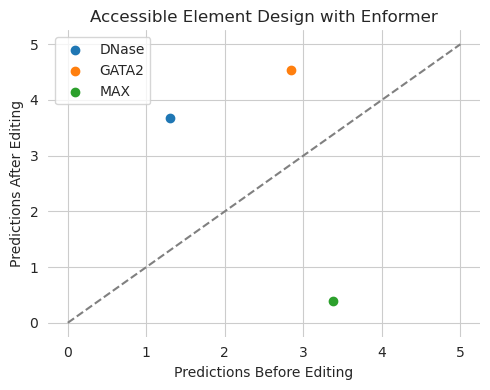

In [14]:
plt.figure(figsize=(5, 4))

plt.title("Accessible Element Design with Enformer")
plt.scatter(y_orig[0, 0], y_hat[0, 0], label="DNase")
plt.scatter(y_orig[0, 1], y_hat[0, 1], label="GATA2")
plt.scatter(y_orig[0, 2], y_hat[0, 2], label="MAX")
plt.plot([0, 5], [0, 5], c='0.5', linestyle='--')

plt.xlabel("Predictions Before Editing")
plt.ylabel("Predictions After Editing")
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

A potential reason why someone may want to use many outputs from the same model is that they are trying to *keep some predictions the same as before editing*. For example, you may want to edit in the binding of certain proteins while keeping transcription levels the same; or vice versa, increase transcription without affecting the binding of certain proteins (including keeping them low). This is conceptually similar to the idea of masking out regions to prevent certain sequence features from being changed, but does not actually requiring knowing what motifs or spans should be left alone, and even allows for the possibility of motifs to be re-arranged so long as the output from the model remains the same. 

In [15]:
y_orig = predict(enformer, X)
y_bar = torch.tensor([[4.0, 5.0, y_orig[0, 2]]])

X_bar = ledidi(enformer, X, y_bar, l=0.001, verbose=True)
y_hat = predict(enformer, X_bar)

iter=I	input_loss=0.0	output_loss=3.973	total_loss=3.973	time=0.0
iter=100	input_loss=254.1	output_loss=0.01027	total_loss=0.2643	time=7.294
iter=200	input_loss=168.9	output_loss=0.006788	total_loss=0.1757	time=7.237
iter=F	input_loss=149.6	output_loss=0.004392	total_loss=0.154	time=20.6


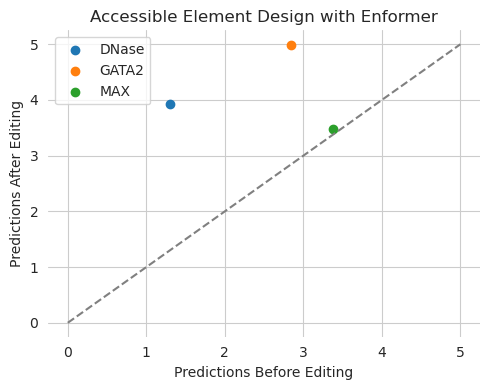

In [16]:
plt.figure(figsize=(5, 4))

plt.title("Accessible Element Design with Enformer")
plt.scatter(y_orig[0, 0], y_hat[0, 0], label="DNase")
plt.scatter(y_orig[0, 1], y_hat[0, 1], label="GATA2")
plt.scatter(y_orig[0, 2], y_hat[0, 2], label="MAX")
plt.plot([0, 5], [0, 5], c='0.5', linestyle='--')

plt.xlabel("Predictions Before Editing")
plt.ylabel("Predictions After Editing")
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

Looks like our edits hit the target values, including keeping the green dot unchanged on the line.

This approach works regardless of the number of outputs from the model you would like to use. For example, we can use all of the chromatin accessibility outputs from Enformer to try to design edits that induce weird patterns of accessibility. Here, we will set the first 50 cell types to a low level of accessibility, set the last 83 cell types to a high level of accessibility, and try to preserve the predictions for all other cell types.

In [17]:
enformer = EnformerWrapper(enformer_base, slice(0, 684, 1))

y_orig = predict(enformer, X)
print(y_orig.shape)

y_bar = torch.clone(y_orig)
y_bar[0, :50] = 1
y_bar[0, 600:] = 6

X_bar = ledidi(enformer, X, y_bar, l=0.0001, verbose=True)[0:1]
y_hat = predict(enformer, X_bar)

torch.Size([1, 684])
iter=I	input_loss=0.0	output_loss=3.007	total_loss=3.007	time=0.0
iter=100	input_loss=350.0	output_loss=2.393	total_loss=2.428	time=7.246
iter=200	input_loss=327.0	output_loss=2.351	total_loss=2.384	time=7.227
iter=300	input_loss=370.4	output_loss=2.349	total_loss=2.386	time=7.238
iter=F	input_loss=343.6	output_loss=2.338	total_loss=2.373	time=25.03


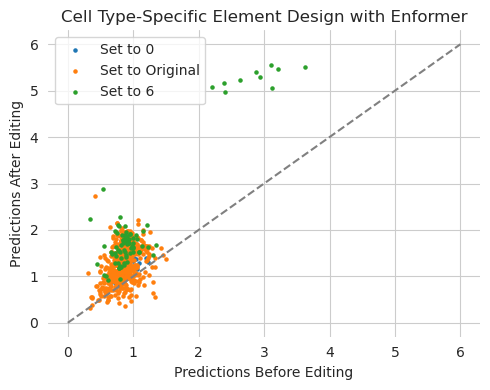

In [18]:
plt.figure(figsize=(5, 4))

plt.title("Cell Type-Specific Element Design with Enformer")
plt.scatter(y_orig[0, :50], y_hat[0, :50], s=5, label="Set to 0")
plt.scatter(y_orig[0, 50:600], y_hat[0, 50:600], s=5, label="Set to Original")
plt.scatter(y_orig[0, 600:], y_hat[0, 600:], s=5, label="Set to 6")
plt.plot([0, 6], [0, 6], c='0.5', linestyle='--')

plt.xlabel("Predictions Before Editing")
plt.ylabel("Predictions After Editing")
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

It does not seem like this design was particularly successful. In retrospect, this makes some amount of sense because there are a large number of redundant and related cell types being modeled by Enformer and they are not necessarily related by order in the list. Some of the cell types we set to high accessibility may have related cell lines we have set to low accessibility, yielding an inconsistent design goal.

Regardless, the purpose of the example was to show how one could specify a design task over many outputs. By using a wrapper to slice out the outputs one wishes to design against and using a vector of desired outputs, one can easily do this. 

#### Using Multiple Models with the Same Input Width

Potentially, the more exciting multi-output scenario is when multiple separate models are being used simultaneously. Having multiple models is also the more likely scenario in practice because the state-of-the-art model for one form of activity may not be state-of-the-art in all of the aspects you care about, or even make predictions for the specific conditions or experiment you care about.

As our first example, let's use a ChromBPNet model, which makes predictions for chromatin accessibility, and a BPNet model that makes predictions for MAX binding. We can load them up the same as before.

In [19]:
from bpnetlite import BPNet
from bpnetlite.bpnet import ControlWrapper
from bpnetlite.bpnet import CountWrapper

X = random_one_hot((1, 4, 2114), random_state=0).float()

chrombpnet = BPNet.from_chrombpnet("../../../../models/chrombpnet/fold_0/model.chrombpnet_nobias.fold_0.ENCSR868FGK.h5")
chrombpnet = CountWrapper(chrombpnet).cuda()

bpnet_max = torch.load("../../../../models/bpnet/MAX.torch", weights_only=False)
bpnet_max = CountWrapper(ControlWrapper(bpnet_max))

The `ControlWraper` and `CountWrapper` objects are not related to use of Ledidi but, rather, automatically supply an all-zeroes control track to the BPNet model and slice out the count output from BPNet and ChromBPNet's predictions. Basically, these are wrappers I usually put around BPNet and ChromBPNet models in all scenarios, not just design.

To combine these models into a single designer, we can import `DesignWrapper`. This class takes in a set of models, runs the input sequence through each one, and concatenates the outputs. Essentially, it takes in a set of models and turns them functionally into a multi-task model like Enformer.

In [20]:
from ledidi.wrappers import DesignWrapper

designer = DesignWrapper([chrombpnet, bpnet_max])

y_orig = predict(designer, X)
y_orig

tensor([[8.4317, 1.4087]])

As you can see, the `designer` object can be used just like any other model and acts like a multi-task model in the sense that it returns a single tensor output with multiple dimensions.

We can use this designer object the same way we used the earlier Enformer wrappers. Specifically, we specify desired outputs for the two tasks (ChromBPNet and BPNet) and then pass the designer object into `ledidi` as if it were a model.

In [21]:
y_bar = torch.tensor([[12.0, 7.0]])

X_bar = ledidi(designer, X, y_bar, verbose=True)
y_hat = predict(designer, X_bar)

iter=I	input_loss=0.0	output_loss=22.0	total_loss=22.0	time=0.0
iter=100	input_loss=98.69	output_loss=1.046	total_loss=10.92	time=4.224
iter=200	input_loss=95.88	output_loss=0.5499	total_loss=10.14	time=3.413
iter=F	input_loss=86.31	output_loss=0.6581	total_loss=9.289	time=9.319


Because the edited sequences have to be passed through multiple models you will notice that the time per tick increases with the number of models being used. This is a small downside to this approach and may limit, in practice, the number of models that can be used at the same time because multiple models may need to live in GPU memory.

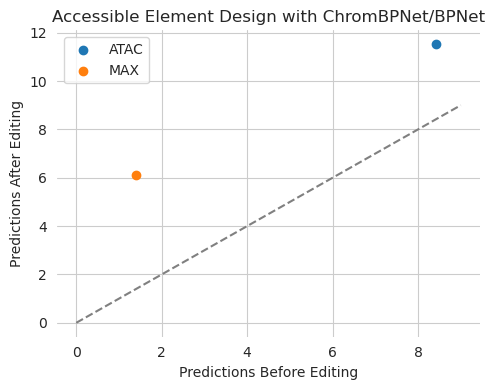

In [22]:
plt.figure(figsize=(5, 4))

plt.title("Accessible Element Design with ChromBPNet/BPNet")
plt.scatter(y_orig[0, 0], y_hat[0, 0], label="ATAC")
plt.scatter(y_orig[0, 1], y_hat[0, 1], label="MAX")
plt.plot([0, 9], [0, 9], c='0.5', linestyle='--')

plt.xlabel("Predictions Before Editing")
plt.ylabel("Predictions After Editing")
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

We tasked Ledidi with designing edits that increased both accessibility (as predicted by ChromBPNet) and MAX binding (as predicted by BPNet). Looks like it was able to successfully do that without needing any code changes other than first wrapping the multiple models in a single `DesignWrapper` class. 

To demonstrate that this works with more than just two models, we can begin by loading up three more BPNet models and including them in the designer.

In [23]:
bpnet_gata = torch.load("../../../../models/bpnet/GATA2.torch", weights_only=False)
bpnet_gata = CountWrapper(ControlWrapper(bpnet_gata))

bpnet_ctcf = torch.load("../../../../models/bpnet/CTCF.torch", weights_only=False)
bpnet_ctcf = CountWrapper(ControlWrapper(bpnet_ctcf))

bpnet_e2f6 = torch.load("../../../../models/bpnet/E2F6.torch", weights_only=False)
bpnet_e2f6 = CountWrapper(ControlWrapper(bpnet_e2f6))

designer = DesignWrapper([chrombpnet, bpnet_max, bpnet_gata, bpnet_ctcf, bpnet_e2f6])

y_orig = predict(designer, X)
y_bar = torch.tensor([[14.0, 7.0, 4.0, 3.0, 8.0]])

X_bar = ledidi(designer, X, y_bar, verbose=True)
y_hat = predict(designer, X_bar)

iter=I	input_loss=0.0	output_loss=22.45	total_loss=22.45	time=0.0
iter=100	input_loss=138.6	output_loss=2.49	total_loss=16.35	time=5.065
iter=200	input_loss=140.1	output_loss=1.644	total_loss=15.66	time=5.068
iter=F	input_loss=128.8	output_loss=1.555	total_loss=14.43	time=14.76


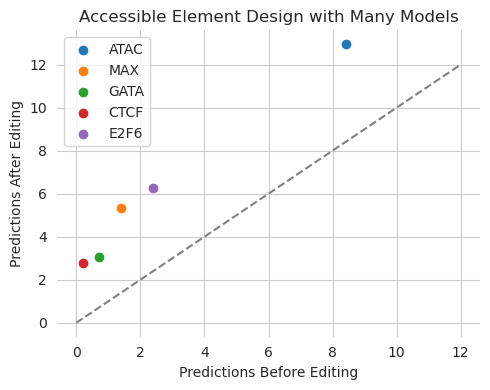

In [24]:
plt.figure(figsize=(5, 4))

plt.title("Accessible Element Design with Many Models")
plt.scatter(y_orig[0, 0], y_hat[0, 0], label="ATAC")
plt.scatter(y_orig[0, 1], y_hat[0, 1], label="MAX")
plt.scatter(y_orig[0, 2], y_hat[0, 2], label="GATA")
plt.scatter(y_orig[0, 3], y_hat[0, 3], label="CTCF")
plt.scatter(y_orig[0, 4], y_hat[0, 4], label="E2F6")
plt.plot([0, 12], [0, 12], c='0.5', linestyle='--')

plt.xlabel("Predictions Before Editing")
plt.ylabel("Predictions After Editing")
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

Looks like Ledidi was able to edit the sequence to make each of the output models exhibit the desired output, even when there are now five models being used at the same time. As mentioned, the time per tick has increased a bit over using only two models. Here, the ChromBPNet model takes most of the time because it is 512 filters per layer while the BPNet models only have 64 filters.

#### Mixing Multiple Models and Multiple Tasks with the Same Input Width

In the previous example, each model provided only one output to the designer. However, this is not a hard restriction and, just to be explicit, <i>each model can provide any number of outputs to the designer</i>. Something to keep in mind, though, is that `DesignWrapper` is simply concatenating the outputs across models and so the user will have to keep track of the indexing of outputs when using many models that each provide a variable number of outputs.

Let's see an example of this where we use three outputs from Enformer -- for accessibility, GATA binding, and MAX binding -- alongside an E2F6 BPNet model. Potentially, a situation like this would arise when one has performed a new experiment and wishes to use a specialist model making predictions for it along with a more established model like Enformer. Alternatively, it can arise when a massively multi-task model does not make accurate predictions for a specific output you care about and you want to "patch" that inaccurate output with a specialist model. Regardless of reason, all you need to do is pass your Enformer wrapper that has sliced out the outputs of interested along with your BPNet model(s), exactly as we did before.

In [25]:
enformer = EnformerWrapper(enformer_base, [625, 1066, 961])

designer = DesignWrapper([enformer, bpnet_e2f6])

Because we are using three outputs from Enformer and one output from BPNet we need to specify a desired target vector that has four values. These will always be ordered in the same way as the models that you have passed in and so will begin with the three outputs from Enformer and then have the BPNet output. 

For this example, let's choose to increase accessibility and GATA binding, decrease MAX binding, and increase E2F6. Just as before, we specify a `y_bar` accordingly and pass the design wrapper into the `ledidi` function.

In [26]:
y_orig = predict(designer, X)
y_bar = torch.tensor([[5.0, 6.0, 0.0, 8.0]])

X_bar = ledidi(designer, X, y_bar, l=0.0001, verbose=True)
y_hat = predict(designer, X_bar)

iter=I	input_loss=0.0	output_loss=17.02	total_loss=17.02	time=0.0
iter=100	input_loss=464.4	output_loss=1.867	total_loss=1.914	time=10.13
iter=200	input_loss=528.6	output_loss=1.09	total_loss=1.143	time=8.179
iter=300	input_loss=554.8	output_loss=1.206	total_loss=1.262	time=8.159
iter=F	input_loss=537.7	output_loss=0.9756	total_loss=1.029	time=27.61


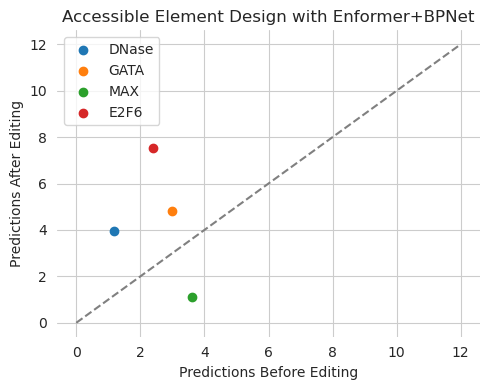

In [27]:
plt.figure(figsize=(5, 4))

plt.title("Accessible Element Design with Enformer+BPNet")
plt.scatter(y_orig[0, 0], y_hat[0, 0], label="DNase")
plt.scatter(y_orig[0, 1], y_hat[0, 1], label="GATA")
plt.scatter(y_orig[0, 2], y_hat[0, 2], label="MAX")
plt.scatter(y_orig[0, 3], y_hat[0, 3], label="E2F6")
plt.plot([0, 12], [0, 12], c='0.5', linestyle='--')

plt.xlabel("Predictions Before Editing")
plt.ylabel("Predictions After Editing")
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

Seems like we were able to achieve our goal, with MAX predictions decreasing and everything else increasing. Just like in the other examples, there was no need to change code once the design wrapper has been created correctly.

#### Mixing Models with Different Input Widths

A serious practical challenge when using multiple models is that they might not take inputs of the same length. In our first example, ChromBPNet and BPNet operate on the same sequence length and so using them together was simple. In the second example, Enformer (reduced down to 2kbp inputs) and BPNet do not operate on exactly the same sequence length but are both a litle bit flexible. However, most models will not be this flexible. In general, any model that has a dense layer in it (outside the transformer layer) will have a hard input sequence restriction. This is part of the reason that I try to avoid those sorts of layers, but many people do not.

As an example, Beluga requires a fixed input sequence length of 2kbp. Let's try it out, using a wrapper similar to Enformer that slices out an output (this time for CTCF) and pairing it with a ChromBPNet model.

In [28]:
import sys

class BelugaWrapper(torch.nn.Module):
    def __init__(self, model, targets):
        super(BelugaWrapper, self).__init__()
        self.model = model
        self.targets = targets
    
    def forward(self, X):
        return self.model(X)[:, self.targets]

sys.path.append("/users/jacob.schreiber/models/deepsea")
from beluga import Beluga

_beluga = Beluga()
_beluga.load_state_dict(torch.load("../../../../models/deepsea/deepsea.beluga.pth", weights_only=False))

beluga = BelugaWrapper(_beluga, [338])

In [29]:
designer = DesignWrapper([chrombpnet.cuda(), beluga.cuda()])

y_orig = predict(designer, X)
y_bar = torch.tensor([[5.0, 6.0]])

X_bar = ledidi(designer, X, y_bar, l=0.0001, verbose=True)
y_hat = predict(designer, X_bar)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x72320 and 67840x2003)

Looks like we get an error message on the `predict` function because the shapes are not correct. Basically, Beluga is expecting a sequence of length 2,000bp exactly. However, we generated a sequence of length 2114bp because that is the normal length for BPNet. Because the dense layer can only be applied to inputs of a specific length, an error is raised.

For this specific example we could just generate a sequence of length 2kbp because BPNet is flexible enough to be applied to sequences of any length. However, as a more general-purpose solution, we can create a wrapper that trims the input sequence to the length expected by each of the models. This would mean passing in an input sequence whose length is equal to the longest one expected by any of the models and working from there.

Accordingly, we will modify our Beluga wrapper to slice out 57bp on either side, bringing the 2,114bp long sequence for BPNet down to 2,000bp when being used by Beluga.

In [30]:
class BelugaWrapper2(torch.nn.Module):
    def __init__(self, model, targets):
        super(BelugaWrapper2, self).__init__()
        self.model = model
        self.targets = targets
    
    def forward(self, X):
        return self.model(X[:, :, 57:-57])[:, self.targets]

beluga = BelugaWrapper2(_beluga, [338])

Now that we have wrapper Beluga in this new wrapper, everything else can proceed exactly the same as before! As mentioned before, wrappers truly are productivity hacks that make everything else work smoothly. Imagine the amount of code that would otherwise need to be written to account for inputs of variable lengths.

In [31]:
designer = DesignWrapper([chrombpnet.cuda(), beluga.cuda()])

y_orig = predict(designer, X)
y_bar = torch.tensor([[12.0, 6.0]])

X_bar = ledidi(designer, X, y_bar, l=0.0001, verbose=True)
y_hat = predict(designer, X_bar)

iter=I	input_loss=0.0	output_loss=91.38	total_loss=91.38	time=0.0
iter=100	input_loss=653.4	output_loss=0.1663	total_loss=0.2317	time=4.03
iter=F	input_loss=859.8	output_loss=0.0389	total_loss=0.1249	time=5.365


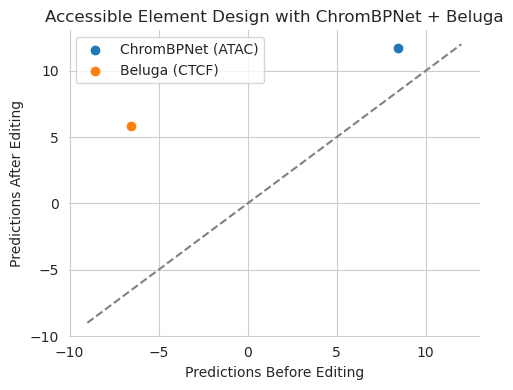

In [32]:
plt.figure(figsize=(5, 4))

plt.title("Accessible Element Design with ChromBPNet + Beluga")
plt.scatter(y_orig[0, 0], y_hat[0, 0], label="ChromBPNet (ATAC)")
plt.scatter(y_orig[0, 1], y_hat[0, 1], label="Beluga (CTCF)")
plt.plot([-9, 12], [-9, 12], c='0.5', linestyle='--')

plt.xlabel("Predictions Before Editing")
plt.ylabel("Predictions After Editing")
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

Looks like everything is working now! Using that wrapper solved the issue and allowed design to proceed exactly the same as the other examples.

It is important to note that simply slicing out the flanks, as we did for Beluga, has some downsides.

First, predictions are only made for the trimmed sequences that are actually passed into the underlying model and not the full sequences that are passed into the designer. As an extreme example, if you passed a 10kbp region into the designer but trimmed this down to 2kbp for Beluga, its predictions are only for that 2kbp region and not for the entire 10kbp region. In our example, going from 2,114bp to 2,000bp probably does not matter at all, but this is something to keep in mind when using models of vastly different sizes.

Second, and relatedly, edits can only be induced in the trimmed sequences that are passed into the models. If you pass in a 10kbp region into the designer but 2kbp into Beluga, it cannot propose edits outside that 2kbp region. This has pros and cons. A benefit of this is that, potentially, you want to focus your edits using Beluga at a specific region in the sequence. A drawback is that the rest of the 10kbp region will be devoid of changes and so if there were better edits that could be made elsewhere, or if you simply need more space to achieve the desired value, you cannot use the rest of this sequence.

Third, taking these two aspects together, when using models that have different receptive fields, Ledidi may try to be "clever" with where it positions edits. Basically, if you say you want a region that is accessible using a 3kbp model but use a 2kbp model to say "but not using CTCF" you may find that CTCF sites are added into the 500bp flanks outside the receptive field of model 2. Technically, this is still achieving the objective because the second model does not see these CTCF sites and will predict low CTCF binding *in the region it has access to*. Basically, Ledidi will try to hide the edits from the models with the smaller receptive field. A potential way to solve this issue is to mask out regions that are not observed by all the models, allowing some models the additional context so that they can actually be run, but disallowing those regions from being used.